Epoch 1/70
17/17 [==============================] - 37s 1s/step - loss: 0.0695
Epoch 2/70
17/17 [==============================] - 25s 1s/step - loss: 0.0191
Epoch 3/70
17/17 [==============================] - 26s 2s/step - loss: 0.0135
Epoch 4/70
17/17 [==============================] - 23s 1s/step - loss: 0.0127
Epoch 5/70
17/17 [==============================] - 25s 1s/step - loss: 0.0121
Epoch 6/70
17/17 [==============================] - 25s 1s/step - loss: 0.0107
Epoch 7/70
17/17 [==============================] - 23s 1s/step - loss: 0.0097
Epoch 8/70
17/17 [==============================] - 25s 1s/step - loss: 0.0089
Epoch 9/70
17/17 [==============================] - 25s 1s/step - loss: 0.0089
Epoch 10/70
17/17 [==============================] - 24s 1s/step - loss: 0.0084
Epoch 11/70
17/17 [==============================] - 23s 1s/step - loss: 0.0082
Epoch 12/70
17/17 [==============================] - 25s 1s/step - loss: 0.0078
Epoch 13/70
17/17 [==============================

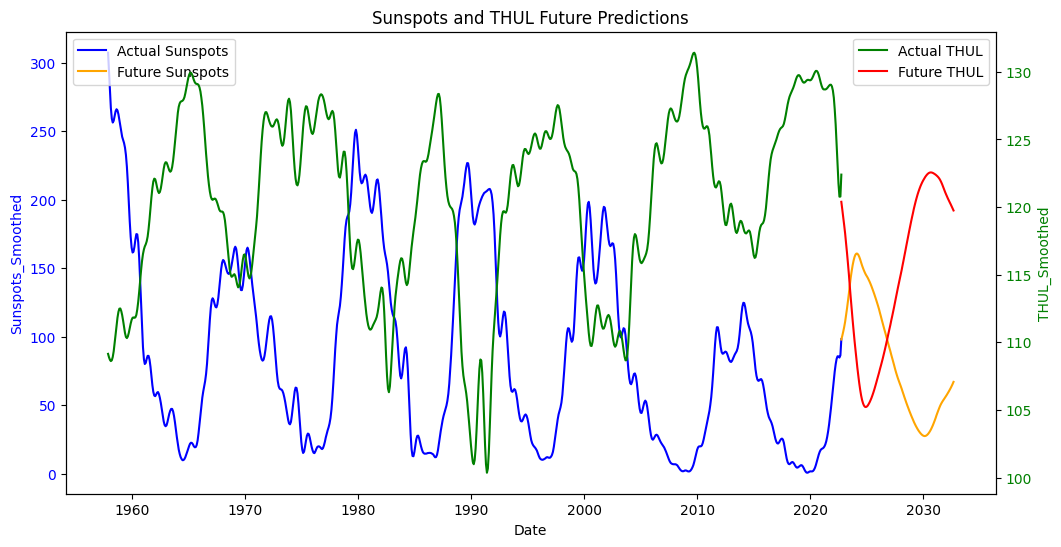

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
raw_data = pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')

# Data preprocessing
columns_to_keep = ['Year', 'Month', 'Sunspots_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_data[['Sunspots_Smoothed', 'THUL_Smoothed']])

# Define the window size
window_size = 240

# Create input sequences and target values
input_sequences = []
target_values = []
for i in range(len(scaled_data) - window_size):
    input_sequences.append(scaled_data[i: i + window_size])
    target_values.append(scaled_data[i + window_size])

input_sequences = np.array(input_sequences)
target_values = np.array(target_values)

# Split the data into training and test sets
train_size = int(0.8 * len(input_sequences))
train_input = input_sequences[:train_size]
train_target = target_values[:train_size]
test_input = input_sequences[train_size:]
test_target = target_values[train_size:]

# Build the model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 2)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(2))  # Output layer with 2 units (for Sunspots_Smoothed and THUL_Smoothed)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the combined dataset
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model.fit(np.concatenate([train_input, test_input]), np.concatenate([train_target, test_target]), epochs=70, batch_size=32, callbacks=[early_stopping])

# Use the last 'window_size' data points from the original dataset as input for prediction
last_input_sequence = scaled_data[-window_size:]
last_input_sequence = last_input_sequence.reshape(1, window_size, 2)  # Reshape for the model input

future_predictions = []  # List to store the future predictions

for _ in range(120):
    prediction = model.predict(last_input_sequence)
    future_predictions.append(prediction[0])  # Append the predicted values to the list

    # Update the input sequence for the next prediction
    last_input_sequence[0, :-1, :] = last_input_sequence[0, 1:, :]  # Shift data one step to the left
    last_input_sequence[0, -1, :] = prediction  # Update the last element with the predicted values

# Inverse transform the scaled predictions to get the actual values
future_predictions = np.array(future_predictions)  # Convert to numpy array
future_predictions = scaler.inverse_transform(future_predictions)

# Get the last date in the original dataset
last_date = new_data['Date'].iloc[-1]

# Generate future dates for the next 120 months
future_dates = pd.date_range(start=last_date, periods=120, freq='MS')


# Plot actual data
plt.figure(figsize=(12, 6))
ax1 = plt.gca()  # Get the current axis

ax1.plot(new_data['Date'], new_data['Sunspots_Smoothed'], label='Actual Sunspots', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunspots_Smoothed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a secondary axis for THUL
ax2 = ax1.twinx()  # Create a twin of the current axis

ax2.plot(new_data['Date'], new_data['THUL_Smoothed'], label='Actual THUL', color='green')
ax2.set_ylabel('THUL_Smoothed', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Plot future predictions
ax1.plot(future_dates, future_predictions[:,0], label='Future Sunspots', color='orange')
ax1.legend(loc='upper left')

# Plot future predictions
ax2.plot(future_dates, future_predictions[:,1], label='Future THUL', color='red')
ax2.legend(loc='upper right')

plt.title('Sunspots and THUL Future Predictions')
plt.show()


model.save('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/model_1st_SolarAndCosmic.h5')

Epoch 1/70
19/19 [==============================] - 37s 1s/step - loss: 0.0723
Epoch 2/70
19/19 [==============================] - 23s 1s/step - loss: 0.0208
Epoch 3/70
19/19 [==============================] - 26s 1s/step - loss: 0.0142
Epoch 4/70
19/19 [==============================] - 22s 1s/step - loss: 0.0126
Epoch 5/70
19/19 [==============================] - 23s 1s/step - loss: 0.0102
Epoch 6/70
19/19 [==============================] - 23s 1s/step - loss: 0.0110
Epoch 7/70
19/19 [==============================] - 21s 1s/step - loss: 0.0109
Epoch 8/70
19/19 [==============================] - 22s 1s/step - loss: 0.0106
Epoch 9/70
19/19 [==============================] - 23s 1s/step - loss: 0.0097
Epoch 10/70
19/19 [==============================] - 21s 1s/step - loss: 0.0090
Epoch 11/70
19/19 [==============================] - 23s 1s/step - loss: 0.0104
Epoch 12/70
19/19 [==============================] - 24s 1s/step - loss: 0.0088
Epoch 13/70
19/19 [==============================

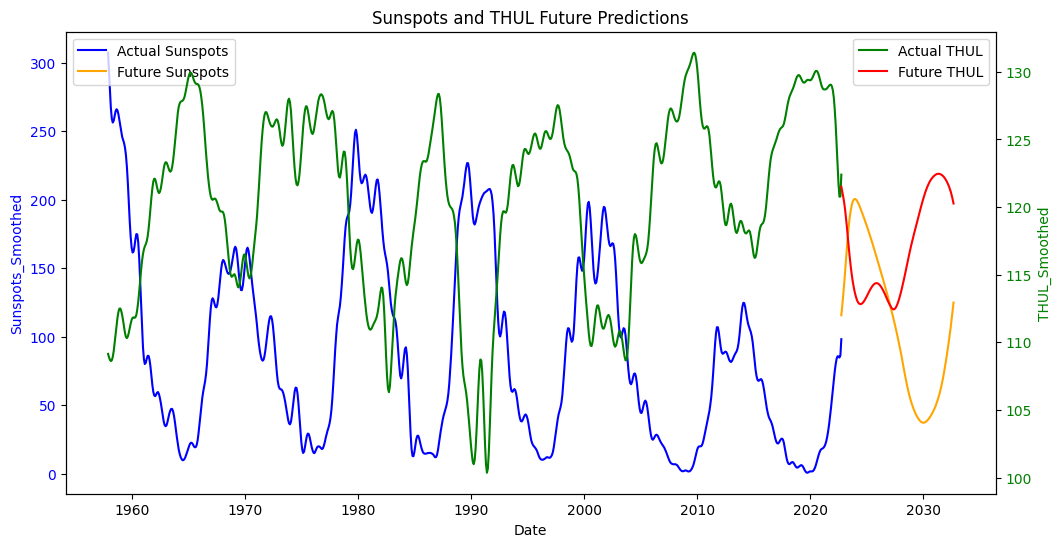

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
raw_data = pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')

# Data preprocessing
columns_to_keep = ['Year', 'Month', 'Sunspots_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_data[['Sunspots_Smoothed', 'THUL_Smoothed']])

# Define the window size
window_size = 200

# Create input sequences and target values
input_sequences = []
target_values = []
for i in range(len(scaled_data) - window_size):
    input_sequences.append(scaled_data[i: i + window_size])
    target_values.append(scaled_data[i + window_size])

input_sequences = np.array(input_sequences)
target_values = np.array(target_values)

# Split the data into training and test sets
train_size = int(0.8 * len(input_sequences))
train_input = input_sequences[:train_size]
train_target = target_values[:train_size]
test_input = input_sequences[train_size:]
test_target = target_values[train_size:]

# Build the model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 2)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(2))  # Output layer with 2 units (for Sunspots_Smoothed and THUL_Smoothed)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the combined dataset
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model.fit(np.concatenate([train_input, test_input]), np.concatenate([train_target, test_target]), epochs=70, batch_size=32, callbacks=[early_stopping])

# Use the last 'window_size' data points from the original dataset as input for prediction
last_input_sequence = scaled_data[-window_size:]
last_input_sequence = last_input_sequence.reshape(1, window_size, 2)  # Reshape for the model input

future_predictions = []  # List to store the future predictions

for _ in range(120):
    prediction = model.predict(last_input_sequence)
    future_predictions.append(prediction[0])  # Append the predicted values to the list

    # Update the input sequence for the next prediction
    last_input_sequence[0, :-1, :] = last_input_sequence[0, 1:, :]  # Shift data one step to the left
    last_input_sequence[0, -1, :] = prediction  # Update the last element with the predicted values

# Inverse transform the scaled predictions to get the actual values
future_predictions = np.array(future_predictions)  # Convert to numpy array
future_predictions = scaler.inverse_transform(future_predictions)

# Get the last date in the original dataset
last_date = new_data['Date'].iloc[-1]

# Generate future dates for the next 120 months
future_dates = pd.date_range(start=last_date, periods=120, freq='MS')


# Plot actual data
plt.figure(figsize=(12, 6))
ax1 = plt.gca()  # Get the current axis

ax1.plot(new_data['Date'], new_data['Sunspots_Smoothed'], label='Actual Sunspots', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunspots_Smoothed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a secondary axis for THUL
ax2 = ax1.twinx()  # Create a twin of the current axis

ax2.plot(new_data['Date'], new_data['THUL_Smoothed'], label='Actual THUL', color='green')
ax2.set_ylabel('THUL_Smoothed', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Plot future predictions
ax1.plot(future_dates, future_predictions[:,0], label='Future Sunspots', color='orange')
ax1.legend(loc='upper left')

# Plot future predictions
ax2.plot(future_dates, future_predictions[:,1], label='Future THUL', color='red')
ax2.legend(loc='upper right')

plt.title('Sunspots and THUL Future Predictions')
plt.show()


model.save('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/model_2nd_SolarAndCosmic.h5')

Epoch 1/70
21/21 [==============================] - 31s 726ms/step - loss: 0.0582
Epoch 2/70
21/21 [==============================] - 15s 735ms/step - loss: 0.0182
Epoch 3/70
21/21 [==============================] - 15s 743ms/step - loss: 0.0141
Epoch 4/70
21/21 [==============================] - 15s 739ms/step - loss: 0.0116
Epoch 5/70
21/21 [==============================] - 15s 739ms/step - loss: 0.0112
Epoch 6/70
21/21 [==============================] - 16s 753ms/step - loss: 0.0106
Epoch 7/70
21/21 [==============================] - 19s 892ms/step - loss: 0.0092
Epoch 8/70
21/21 [==============================] - 15s 733ms/step - loss: 0.0097
Epoch 9/70
21/21 [==============================] - 15s 734ms/step - loss: 0.0102
Epoch 10/70
21/21 [==============================] - 17s 818ms/step - loss: 0.0093
Epoch 11/70
21/21 [==============================] - 17s 756ms/step - loss: 0.0086
Epoch 12/70
21/21 [==============================] - 15s 740ms/step - loss: 0.0090
Epoch 13/70
2

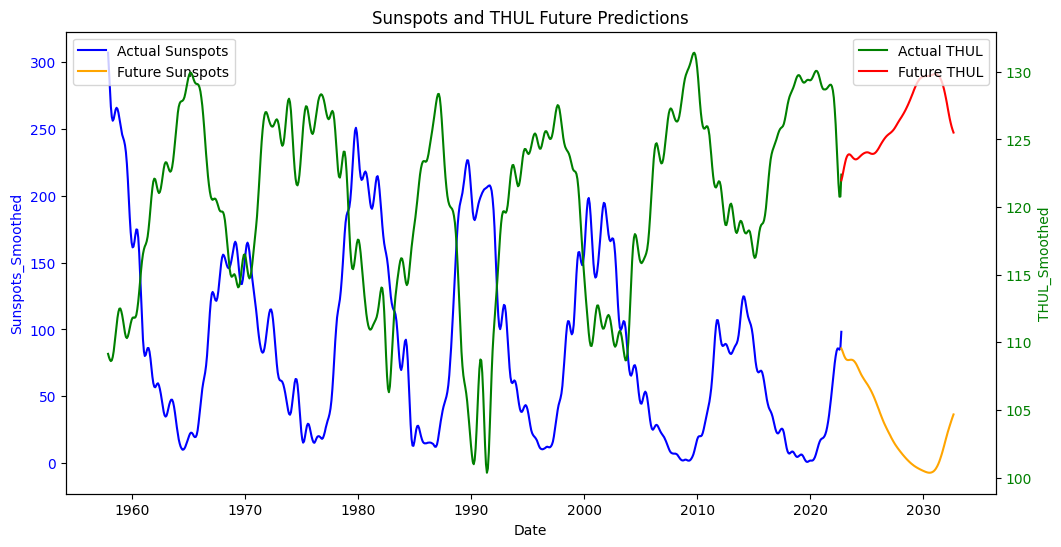

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
raw_data = pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')

# Data preprocessing
columns_to_keep = ['Year', 'Month', 'Sunspots_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_data[['Sunspots_Smoothed', 'THUL_Smoothed']])

# Define the window size
window_size = 120

# Create input sequences and target values
input_sequences = []
target_values = []
for i in range(len(scaled_data) - window_size):
    input_sequences.append(scaled_data[i: i + window_size])
    target_values.append(scaled_data[i + window_size])

input_sequences = np.array(input_sequences)
target_values = np.array(target_values)

# Split the data into training and test sets
train_size = int(0.8 * len(input_sequences))
train_input = input_sequences[:train_size]
train_target = target_values[:train_size]
test_input = input_sequences[train_size:]
test_target = target_values[train_size:]

# Build the model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 2)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(2))  # Output layer with 2 units (for Sunspots_Smoothed and THUL_Smoothed)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the combined dataset
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model.fit(np.concatenate([train_input, test_input]), np.concatenate([train_target, test_target]), epochs=70, batch_size=32, callbacks=[early_stopping])

# Use the last 'window_size' data points from the original dataset as input for prediction
last_input_sequence = scaled_data[-window_size:]
last_input_sequence = last_input_sequence.reshape(1, window_size, 2)  # Reshape for the model input

future_predictions = []  # List to store the future predictions

for _ in range(120):
    prediction = model.predict(last_input_sequence)
    future_predictions.append(prediction[0])  # Append the predicted values to the list

    # Update the input sequence for the next prediction
    last_input_sequence[0, :-1, :] = last_input_sequence[0, 1:, :]  # Shift data one step to the left
    last_input_sequence[0, -1, :] = prediction  # Update the last element with the predicted values

# Inverse transform the scaled predictions to get the actual values
future_predictions = np.array(future_predictions)  # Convert to numpy array
future_predictions = scaler.inverse_transform(future_predictions)

# Get the last date in the original dataset
last_date = new_data['Date'].iloc[-1]

# Generate future dates for the next 120 months
future_dates = pd.date_range(start=last_date, periods=120, freq='MS')


# Plot actual data
plt.figure(figsize=(12, 6))
ax1 = plt.gca()  # Get the current axis

ax1.plot(new_data['Date'], new_data['Sunspots_Smoothed'], label='Actual Sunspots', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunspots_Smoothed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a secondary axis for THUL
ax2 = ax1.twinx()  # Create a twin of the current axis

ax2.plot(new_data['Date'], new_data['THUL_Smoothed'], label='Actual THUL', color='green')
ax2.set_ylabel('THUL_Smoothed', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Plot future predictions
ax1.plot(future_dates, future_predictions[:,0], label='Future Sunspots', color='orange')
ax1.legend(loc='upper left')

# Plot future predictions
ax2.plot(future_dates, future_predictions[:,1], label='Future THUL', color='red')
ax2.legend(loc='upper right')

plt.title('Sunspots and THUL Future Predictions')
plt.show()


model.save('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/model_3rd_SolarAndCosmic.h5')

Epoch 1/70
15/15 [==============================] - 41s 2s/step - loss: 0.0818
Epoch 2/70
15/15 [==============================] - 28s 2s/step - loss: 0.0222
Epoch 3/70
15/15 [==============================] - 29s 2s/step - loss: 0.0155
Epoch 4/70
15/15 [==============================] - 28s 2s/step - loss: 0.0133
Epoch 5/70
15/15 [==============================] - 28s 2s/step - loss: 0.0140
Epoch 6/70
15/15 [==============================] - 28s 2s/step - loss: 0.0114
Epoch 7/70
15/15 [==============================] - 30s 2s/step - loss: 0.0134
Epoch 8/70
15/15 [==============================] - 28s 2s/step - loss: 0.0115
Epoch 9/70
15/15 [==============================] - 28s 2s/step - loss: 0.0102
Epoch 10/70
15/15 [==============================] - 28s 2s/step - loss: 0.0101
Epoch 11/70
15/15 [==============================] - 28s 2s/step - loss: 0.0099
Epoch 12/70
15/15 [==============================] - 28s 2s/step - loss: 0.0090
Epoch 13/70
15/15 [==============================

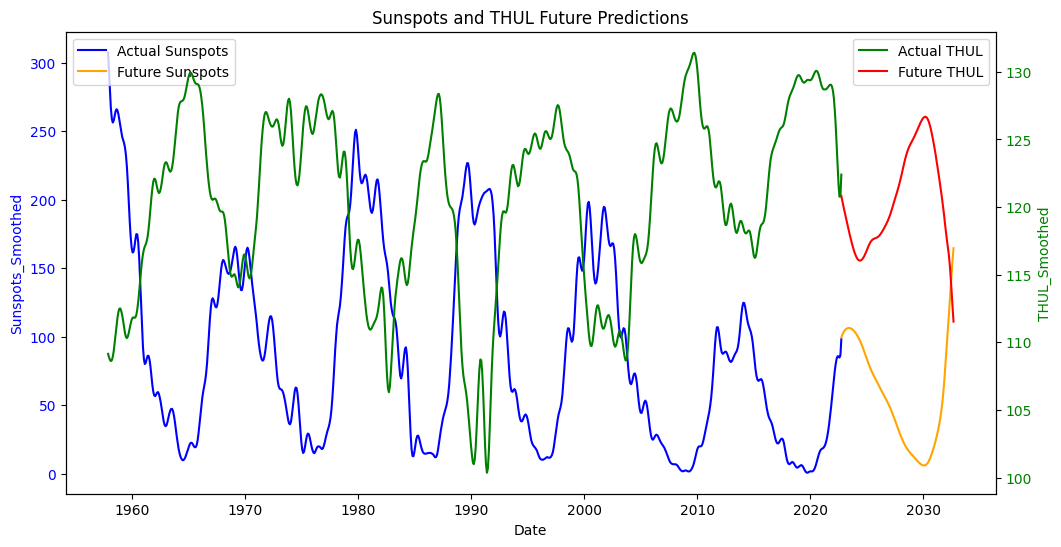

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
raw_data = pd.read_excel('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/All_Data_Stitched.xlsx')

# Data preprocessing
columns_to_keep = ['Year', 'Month', 'Sunspots_Smoothed', 'THUL_Smoothed']
new_data = raw_data.loc[:, columns_to_keep]
new_data['Date'] = pd.to_datetime(new_data[['Year', 'Month']].assign(day=1))
new_data.drop(['Year', 'Month'], axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(new_data[['Sunspots_Smoothed', 'THUL_Smoothed']])

# Define the window size
window_size = 300

# Create input sequences and target values
input_sequences = []
target_values = []
for i in range(len(scaled_data) - window_size):
    input_sequences.append(scaled_data[i: i + window_size])
    target_values.append(scaled_data[i + window_size])

input_sequences = np.array(input_sequences)
target_values = np.array(target_values)

# Split the data into training and test sets
train_size = int(0.8 * len(input_sequences))
train_input = input_sequences[:train_size]
train_target = target_values[:train_size]
test_input = input_sequences[train_size:]
test_target = target_values[train_size:]

# Build the model
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(window_size, 2)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.2))

model.add(Dense(2))  # Output layer with 2 units (for Sunspots_Smoothed and THUL_Smoothed)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the combined dataset
early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model.fit(np.concatenate([train_input, test_input]), np.concatenate([train_target, test_target]), epochs=70, batch_size=32, callbacks=[early_stopping])

# Use the last 'window_size' data points from the original dataset as input for prediction
last_input_sequence = scaled_data[-window_size:]
last_input_sequence = last_input_sequence.reshape(1, window_size, 2)  # Reshape for the model input

future_predictions = []  # List to store the future predictions

for _ in range(120):
    prediction = model.predict(last_input_sequence)
    future_predictions.append(prediction[0])  # Append the predicted values to the list

    # Update the input sequence for the next prediction
    last_input_sequence[0, :-1, :] = last_input_sequence[0, 1:, :]  # Shift data one step to the left
    last_input_sequence[0, -1, :] = prediction  # Update the last element with the predicted values

# Inverse transform the scaled predictions to get the actual values
future_predictions = np.array(future_predictions)  # Convert to numpy array
future_predictions = scaler.inverse_transform(future_predictions)

# Get the last date in the original dataset
last_date = new_data['Date'].iloc[-1]

# Generate future dates for the next 120 months
future_dates = pd.date_range(start=last_date, periods=120, freq='MS')


# Plot actual data
plt.figure(figsize=(12, 6))
ax1 = plt.gca()  # Get the current axis

ax1.plot(new_data['Date'], new_data['Sunspots_Smoothed'], label='Actual Sunspots', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sunspots_Smoothed', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a secondary axis for THUL
ax2 = ax1.twinx()  # Create a twin of the current axis

ax2.plot(new_data['Date'], new_data['THUL_Smoothed'], label='Actual THUL', color='green')
ax2.set_ylabel('THUL_Smoothed', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Plot future predictions
ax1.plot(future_dates, future_predictions[:,0], label='Future Sunspots', color='orange')
ax1.legend(loc='upper left')

# Plot future predictions
ax2.plot(future_dates, future_predictions[:,1], label='Future THUL', color='red')
ax2.legend(loc='upper right')

plt.title('Sunspots and THUL Future Predictions')
plt.show()


model.save('/content/drive/MyDrive/iPad/Notes/Διάφορα/Solar 25th Cycle Prediction/model_4rth_SolarAndCosmic.h5')